In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from warnings import filterwarnings
import matplotlib.pyplot as plt

# Uyarıları göz ardı et
filterwarnings('ignore')


In [3]:
data = pd.read_csv("../input/ortopedik/ortopedik.csv")
df = data.copy()
df.head()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


# Keşifsel Veri Analizi (EDA)

Bu veri seti, omurganın ortopedik sağlık durumu ile ilgili sınıflandırma yapmak için kullanılan bir veri kümesidir. Özellikle, hastaların omurga rahatsızlıklarını sınıflandırmak amacıyla kullanılır. Omurganın farklı özellikleri ölçülerek anormal ya da normal bir durumu teşhis etmeyi hedefler.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          310 non-null    float64
 1   pelvic_tilt numeric       310 non-null    float64
 2   lumbar_lordosis_angle     310 non-null    float64
 3   sacral_slope              310 non-null    float64
 4   pelvic_radius             310 non-null    float64
 5   degree_spondylolisthesis  310 non-null    float64
 6   class                     310 non-null    object 
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


**Veri Seti Özeti:**
Kayıt Sayısı: 310
Özellik Sayısı: 7

**Özelliklerin Tanımları**
* **pelvic_incidence (PI):** Pelvis insidansı. Pelvis'in eğimini ölçen bir açı.
* **pelvic_tilt numeric (PT):** Pelvis eğilimi. Pelvis'in dikey eksene göre açısını ölçer.
* **lumbar_lordosis_angle (LLA):** Lomber lordoz açısı. Omurganın alt kısmındaki doğal iç bükey eğrinin açısını ölçer.
* **sacral_slope (SS):** Sakral eğim. Sakrum kemiğinin yatay eksene göre açısını ölçer.
* **pelvic_radius (PR):** Pelvis yarıçapı. Pelvis'in anatomik büyüklüğünü temsil eder.
* **degree_spondylolisthesis (DS):** Spondilolistezis derecesi. Omurların ileri-geri kaymasını ölçer.
* **class:** Hedef değişken. İki sınıf içerir:
Abnormal: Anormal durum.
Normal: Normal durum.

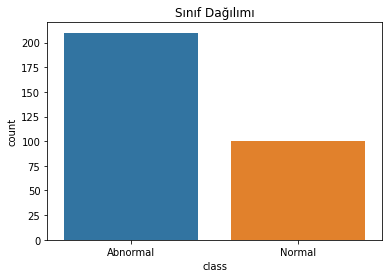

In [5]:
sns.countplot(x='class', data=df)
plt.title('Sınıf Dağılımı')
plt.show()

Bağımlı değişkenimizin (Class) sınıf dağılımları:  "Abnormal" sınıfında 210 kayıt varken, "Normal" sınıfında sadece 100 kayıt bulunuyor.

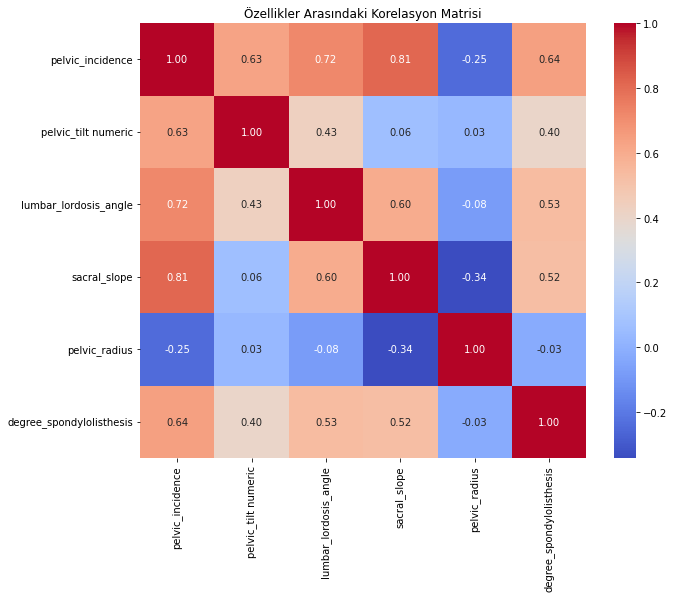

In [6]:
# Sayısal sütunlar arasındaki korelasyonları hesaplayalım
corr_matrix = df.corr()

# Korelasyonları görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Özellikler Arasındaki Korelasyon Matrisi')
plt.show()

**Korelasyon Analizi**
* pelvic_incidence ve sacral_slope arasında yüksek korelasyon mevcut.
* lumbar_lordosis_angle ve sacral_slope arasında da anlamlı bir pozitif korelasyon var.
* pelvic_incidence, lumbar_lordosis_angle ve sacral_slope genel olarak diğer özelliklerle pozitif korelasyona sahip.
* pelvic_radius ile diğer özellikler arasında zayıf korelasyon var.

In [7]:
summary_stats = df.groupby('class').describe().T
summary_stats

class                             Abnormal      Normal
pelvic_incidence         count  210.000000  100.000000
                         mean    64.692562   51.685244
                         std     17.662129   12.368161
                         min     26.147921   30.741938
                         25%     50.102507   42.817849
                         50%     65.274888   50.123115
                         75%     77.593672   61.470097
                         max    129.834041   89.834676
pelvic_tilt numeric      count  210.000000  100.000000
                         mean    19.791111   12.821414
                         std     10.515871    6.778503
                         min     -6.554948   -5.845994
                         25%     13.048130    8.799951
                         50%     18.798899   13.482435
                         75%     24.815515   16.785953
                         max     49.431864   29.894119
lumbar_lordosis_angle    count  210.000000  100.000000
                         mean    55.925370   43.542605
                         std     19.669471   12.361388
                         min     14.000000   19.071075
                         25%     41.116964   35.000000
                         50%     56.150000   42.638923
                         75%     68.102805   51.602346
                         max    125.742385   90.563461
sacral_slope             count  210.000000  100.000000
                         mean    44.901450   38.863830
                         std     14.515560    9.624004
                         min     13.366931   17.386972
                         25%     34.380345   32.340487
                         50%     44.639597   37.059694
                         75%     55.146868   44.608788
                         max    121.429566   67.195460
pelvic_radius            count  210.000000  100.000000
                         mean   115.077713  123.890834
                         std     14.090605    9.014246
                         min     70.082575  100.501192
                         25%    107.309280  118.182659
                         50%    115.650323  123.874328
                         75%    123.133365  129.040401
                         max    163.071041  147.894637
degree_spondylolisthesis count  210.000000  100.000000
                         mean    37.777705    2.186572
                         std     40.696741    6.307483
                         min    -10.675871  -11.058179
                         25%      7.263227   -1.511360
                         50%     31.946516    1.152710
                         75%     55.371614    4.968807
                         max    418.543082   31.172767

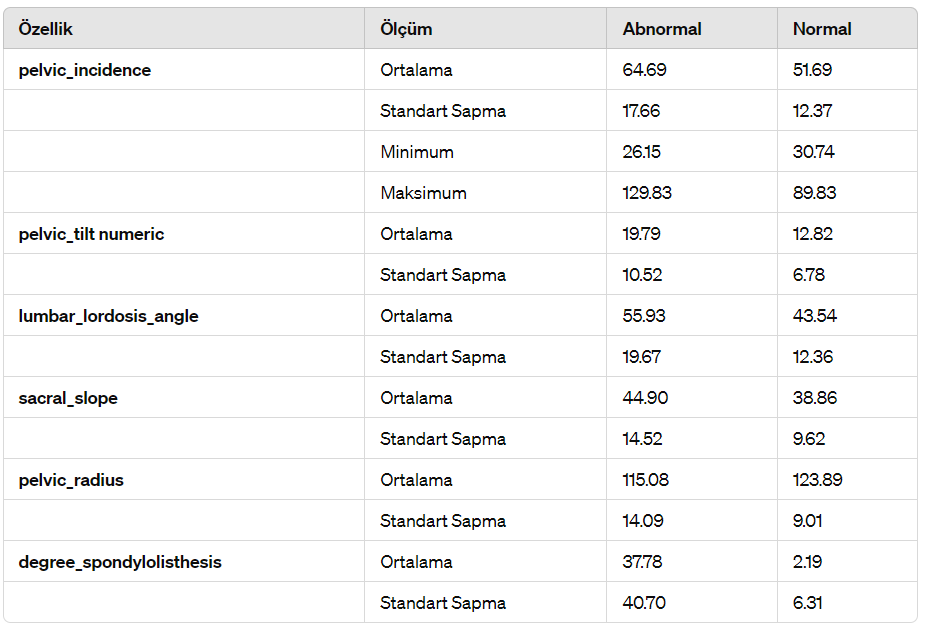

**Yukarıda tabloda bağımsız değişkenlerin bağımlı değişkene göre betimsel istatistikleri verilmiştir.**

# Veri Görselleştirme

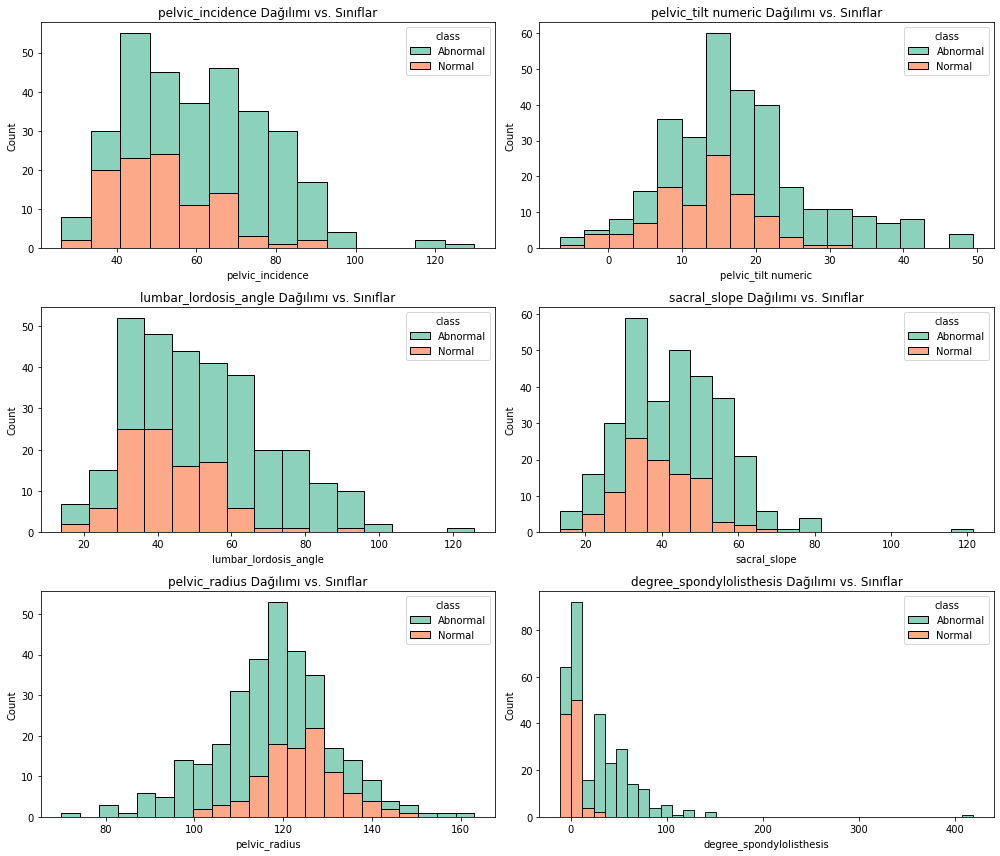

In [8]:
# Özellik dağılımı vs. Sınıflar
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
features = ['pelvic_incidence', 'pelvic_tilt numeric', 'lumbar_lordosis_angle',
            'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(data=df, x=feature, hue='class', multiple='stack', palette='Set2', ax=axes[i])
    axes[i].set_title(f'{feature} Dağılımı vs. Sınıflar')

plt.tight_layout()
plt.show()


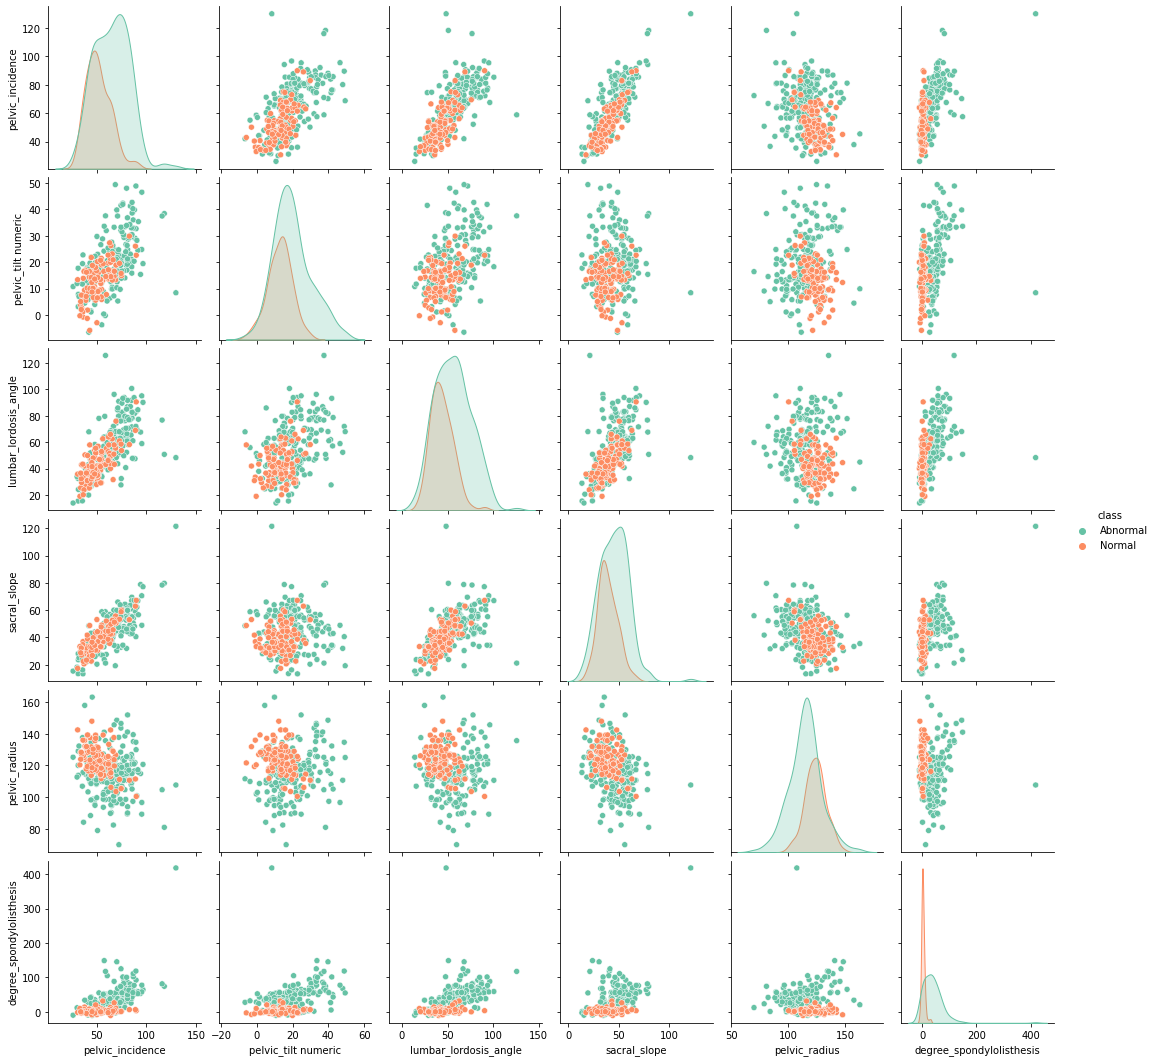

In [9]:
# Pairplot (Özellikler Arası İlişkiler)
sns.pairplot(df, hue='class', palette='Set2')
plt.show()


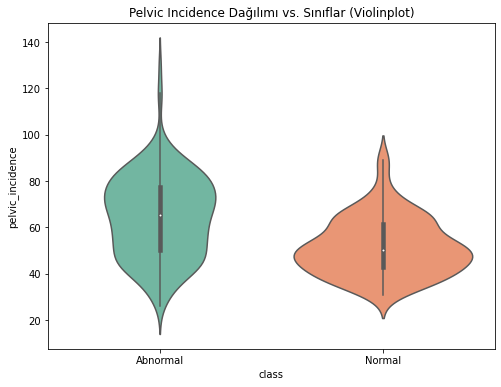

In [10]:
# Violinplot (Pelvic Incidence vs. Sınıflar)
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x='class', y='pelvic_incidence', palette='Set2')
plt.title('Pelvic Incidence Dağılımı vs. Sınıflar (Violinplot)')
plt.show()


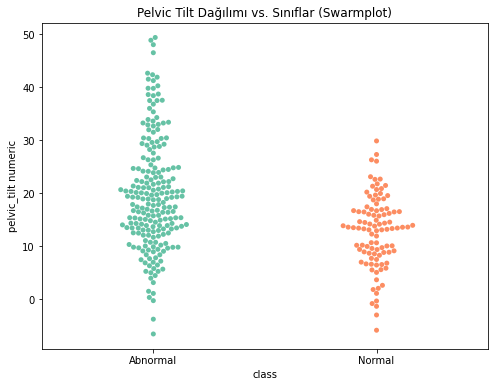

In [11]:
# Swarmplot (Pelvic Tilt vs. Sınıflar)
plt.figure(figsize=(8, 6))
sns.swarmplot(data=df, x='class', y='pelvic_tilt numeric', palette='Set2')
plt.title('Pelvic Tilt Dağılımı vs. Sınıflar (Swarmplot)')
plt.show()


# Veri Ön İşleme

In [12]:
df['class'] = df['class'].apply(lambda x: 1 if x == 'Abnormal' else 0)

* **Class sütununu sayısala çevirdik. Binary Sınıflandırma yapacağımız için 1 ve 0 olarak ayarladık. (1: Abnormal, 0: Normal)**

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          310 non-null    float64
 1   pelvic_tilt numeric       310 non-null    float64
 2   lumbar_lordosis_angle     310 non-null    float64
 3   sacral_slope              310 non-null    float64
 4   pelvic_radius             310 non-null    float64
 5   degree_spondylolisthesis  310 non-null    float64
 6   class                     310 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 17.1 KB


* Yukarıda değişkenlerimizin Dtype değerlerinde bütün değerlerin sayısal olduğu görünmektedir. Şimdi eksik değerlerimiz varmı onu inceleyelim, daha sonra aykırı değer incelemesi yapalım.
* Eğer diğer değerlerimizde sayısal tipte olmasaydı, sayısala çevirmemiz gerekiyordu. Makine öğrenmesine verebilmemiz için bütün değerlerimiz sayısal olması gerekiyor genel olarak.

In [14]:
eksikdeğerler = df.isnull().sum()
print(eksikdeğerler)

pelvic_incidence            0
pelvic_tilt numeric         0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
class                       0
dtype: int64


**Yukarıdaki setimizi incelediğimizde eksik değer görünmemektedir.Eğer eksik değerler olsaydı, eksik değerden kurtulma yöntemleri**: 
* Eksik değer silinebilir, 
* ortalama ile doldurulabilir, 
* en çok tekrar eden değer ile doldurulabilir.

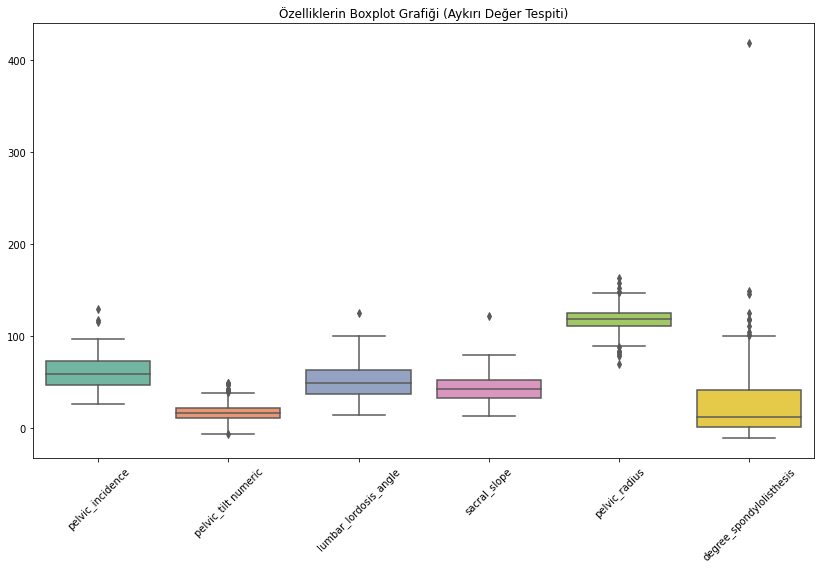

In [15]:
# Aykırı değerleri incelemek için boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(data=df.drop(columns=['class']), palette='Set2')
plt.title('Özelliklerin Boxplot Grafiği (Aykırı Değer Tespiti)')
plt.xticks(rotation=45)
plt.show()

* Aykırı değerlerimizi Alt ve üst sınırlar (Çeyreklikler) belirlenerek, aykırı değerler bu sınırlara çekilecektir. Bu yönteme genellikle **Winsorization** denir. Baskılama yöntemi olarak da geçmektedir.

In [16]:
# Winsorization fonksiyonu
def winsorize_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].apply(lambda x: max(min(x, upper_bound), lower_bound))
    
# Tüm sayısal sütunlar için Winsorization uygulama
for feature in features:
    winsorize_iqr(df, feature)

**winsorize_iqr fonksiyonu ile baskılama işlemi yapılmaktadır. İki tane parametre almaktadır. İlk parametre veri seti, ikinci parametre kolonları (Özellikleri) almaktadır. Biz yukarı kısımda (Veri Görselleştirme) features değişkenine kolonları atamıştık. For döngüsü ile kolonları teker teker fonksiyona verdik. Böylece aykırı değerler alt limite ve üst limite eşitlenmiş oldu.**

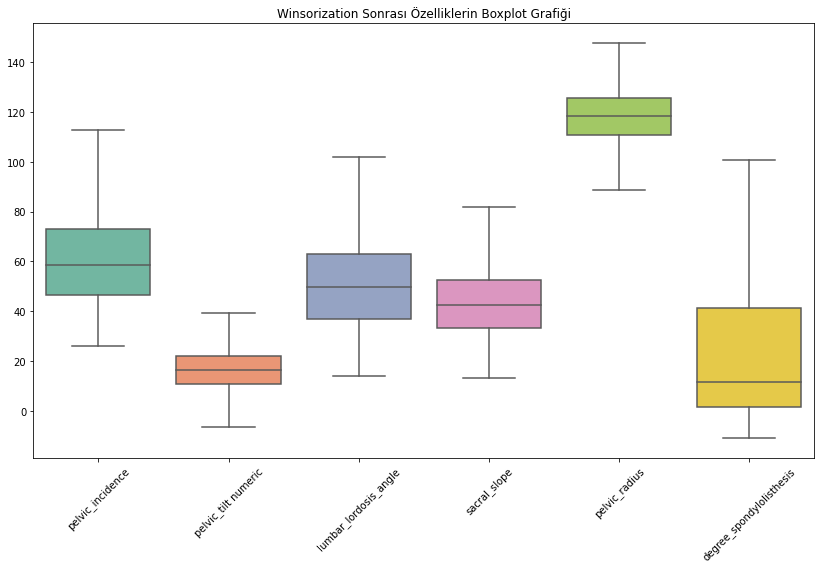

In [17]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=df.drop(columns=['class']), palette='Set2')
plt.title('Winsorization Sonrası Özelliklerin Boxplot Grafiği')
plt.xticks(rotation=45)
plt.show()

* Yukarıda aykırı değerlerin kalmadığı görünmektedir. Görsel aralığı 0-400 iken, 0 ile 140'a düştüğü için görsel daha büyük görünmektedir.

# Makine Öğrenmesi

In [19]:
y = df["class"] 
X = df.drop(['class'], axis=1) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) 

**Gaussian Naive Bayes modeli**

In [20]:
nb = GaussianNB() 
nb_model = nb.fit(X_train, y_train) 
nb_model 

GaussianNB()

In [29]:
y_pred = nb_model.predict(X_test) 
print(f'Test Hatası: {accuracy_score(y_test, y_pred)}')

Test Hatası: 0.7956989247311828


In [30]:
dogrulanmis = cross_val_score(nb_model, X_test, y_test, cv = 10).mean() 
print(f'Doğrulanmış Test Hatası: {dogrulanmis}')

Doğrulanmış Test Hatası: 0.8066666666666666


**K-En Yakın Komşu (KNN)**

In [31]:
knn = KNeighborsClassifier() 
knn_model = knn.fit(X_train, y_train) 
knn_model 

KNeighborsClassifier()

In [32]:
y_pred = knn_model.predict(X_test) 
print(f'Test Hatası: {accuracy_score(y_test, y_pred)}')

Test Hatası: 0.7849462365591398


In [34]:
dogrulanmis = cross_val_score(knn_model, X_test, y_test, cv = 10).mean() 
print(f'Doğrulanmış Test Hatası: {dogrulanmis}')

Doğrulanmış Test Hatası: 0.8466666666666667


**En iyi paremetreleri bulma (KNN)**

In [35]:
knn_params = {"n_neighbors": np.arange(1,50)} 
knn = KNeighborsClassifier() 
knn_cv = GridSearchCV(knn, knn_params, cv=10) 
knn_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

* Komşu sayımız 1 den 50 ye kadar olan değerleri alsın. 
* Komşu sayısı parametresini değiştirip deneyecek. 

In [37]:
print("En iyi skor:" + str(knn_cv.best_score_)) 
print("En iyi parametre (Komşuluk değeri): " + str(knn_cv.best_params_)) 

En iyi skor:0.8523809523809524
En iyi parametre (Komşuluk değeri): {'n_neighbors': 13}


**Destek Vektör Makineleri (SVM)**

In [38]:
svm_model = SVC(kernel = "linear").fit(X_train, y_train) 
y_pred = svm_model.predict(X_test) 
accuracy_score(y_test, y_pred)

0.8924731182795699